# VSE CA1 Part1

### Team
Kenneth Goh Chia Wei : A0198544N  
Tan Heng Han : A0198502B  
Raymond Ng Boon Cheong : A0198543R

In [2]:
import urllib.request
import shutil
import imgaug as ia
import os
from YOLO_API import *

In [2]:
# Download YOLOV3 Pretrained Weights
# This is a shortcut to download the pretrained weights, please ensure that the pretrained weights are fully downloaded before executing further cells
# If download code does not work, please cut and paste URL link below and paste into a browser address field to begin download
url = 'https://drive.google.com/file/d/1Y0E928LRsa1qmP_5P8jHfzSbI8A9T2Pb/view?usp=sharing'
with urllib.request.urlopen(url) as response, open('Yolov3_pretrained_weights.h5', 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

In [3]:
# Dataset directory
img_dir = "../data/image/"
anno_dir = "../data/annotation/"

In [4]:
# Construct YOLOv3 API object
yoloAPI = YoloV3_API(
    img_dir=img_dir,
    annotation_dir=anno_dir,
    saved_model_name='yolo_model.h5',
    train_size=0.8,
    height=416,
    width=416,
    threshold=0.3,
    batch_size=2)

Image directory: ../data/image/
Annotation directory: ../data/annotation/
Saved model name: Final_YOLOv3_Weights_2.h5
Train/validation size ratio: 0.8
Training size: 416x416
Threshold: 0.3
Batch Size: 3

All Image and annotation size: 765
Unique labels: dict_keys(['car', 'bus'])
Generated Anchor Boxes: [8, 10, 14, 18, 24, 26, 35, 46, 41, 29, 48, 94, 64, 48, 85, 76, 92, 120]

Training image and annotation size: 612
Validation image and annotation size: 153
Maximum bounding boxes in all images: 15

Train Generator created: To access, use <YoloV3_API.train_generator>
Validation Generator created: To access, use <YoloV3_API.valid_generator>







Instructions for updating:
Use `tf.cast` instead.

Loading pretrained weights
YOLOv3 Training Model created: To access, use <YoloV3_API.train_model>

YOLOv3 Inference Model created: To access, use <YoloV3_API.infer_model>

Train Model Summary
__________________________________________________________________________________________________
Layer 

In [11]:
%%time
history = yoloAPI.fit_generator(epoch=300, lr=1e-4)


Epoch 1/300
204/204 [==============================] - 121s 594ms/step - loss: 55.9502 - yolo_loss_layer_4_loss: 10.0660 - yolo_loss_layer_5_loss: 12.0076 - yolo_loss_layer_6_loss: 31.5455 - val_loss: 77.5138 - val_yolo_loss_layer_4_loss: 15.5045 - val_yolo_loss_layer_5_loss: 21.5250 - val_yolo_loss_layer_6_loss: 38.1523

Epoch 00001: loss improved from inf to 55.95018, saving model to yolo_model.h5
Epoch 2/300
204/204 [==============================] - 90s 444ms/step - loss: 30.1842 - yolo_loss_layer_4_loss: 5.4354 - yolo_loss_layer_5_loss: 6.5401 - yolo_loss_layer_6_loss: 15.8763 - val_loss: 62.8376 - val_yolo_loss_layer_4_loss: 39.0894 - val_yolo_loss_layer_5_loss: 6.2786 - val_yolo_loss_layer_6_loss: 15.1370

Epoch 00002: loss improved from 55.95018 to 30.18419, saving model to yolo_model.h5
Epoch 3/300
204/204 [==============================] - 92s 451ms/step - loss: 25.7874 - yolo_loss_layer_4_loss: 4.9218 - yolo_loss_layer_5_loss: 5.6681 - yolo_loss_layer_6_loss: 12.8652 - val_

In [5]:
# Get all test images
imgpath = '../data/test_image/'
test_images = os.listdir(imgpath)

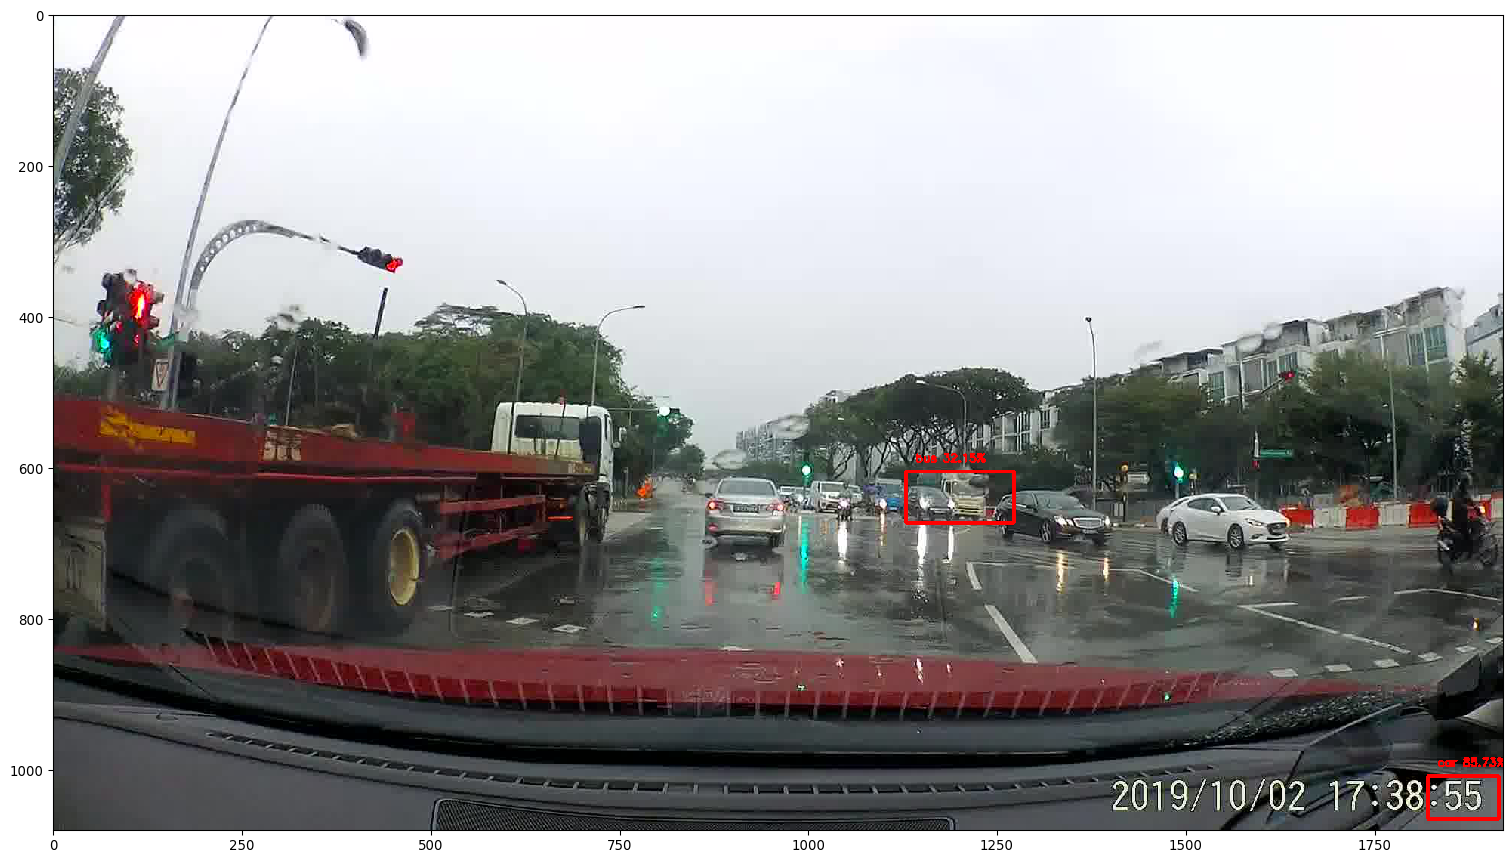

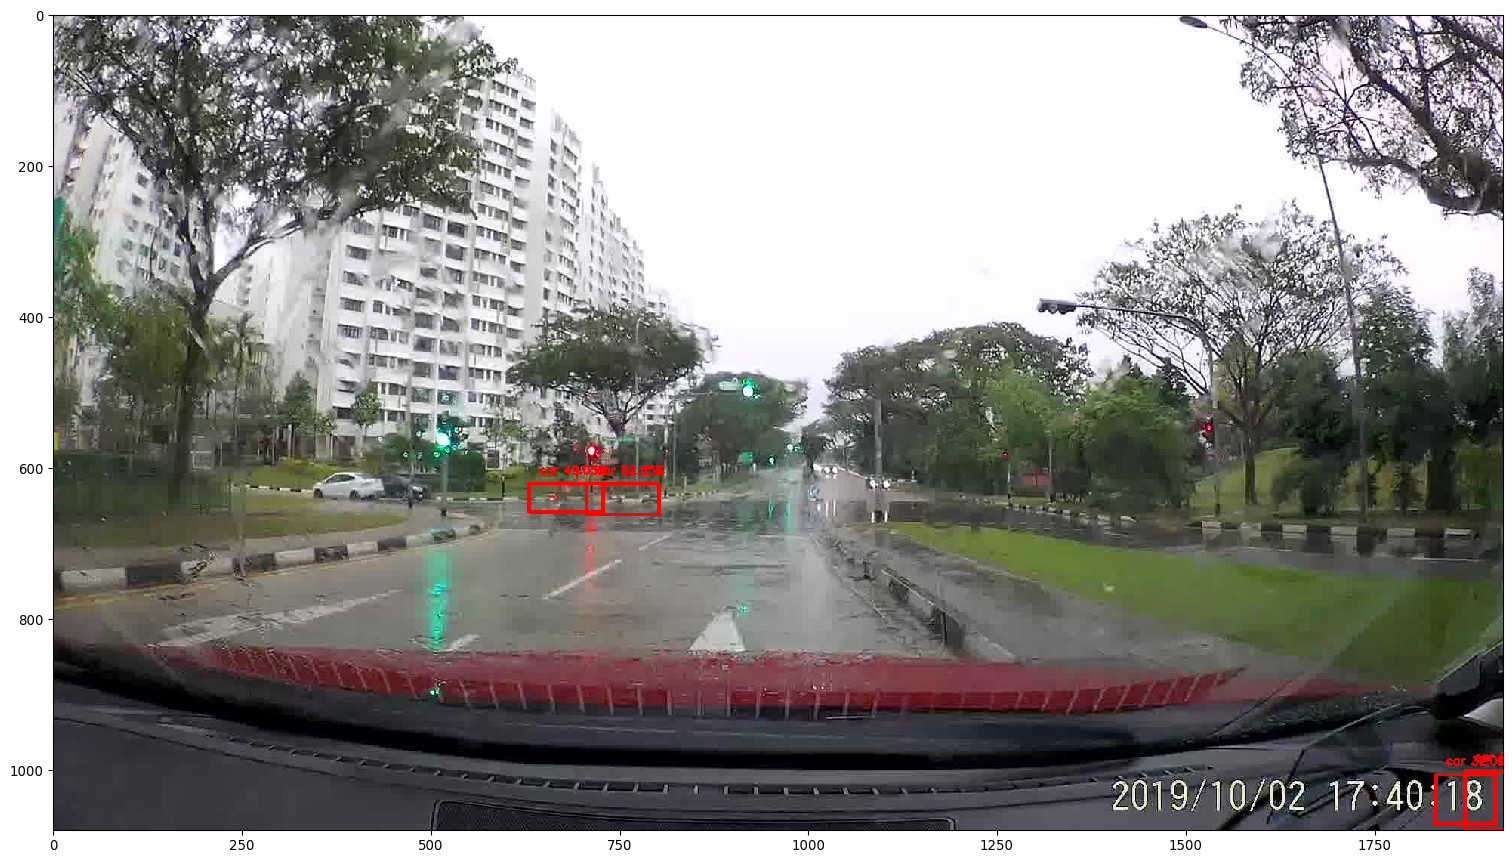

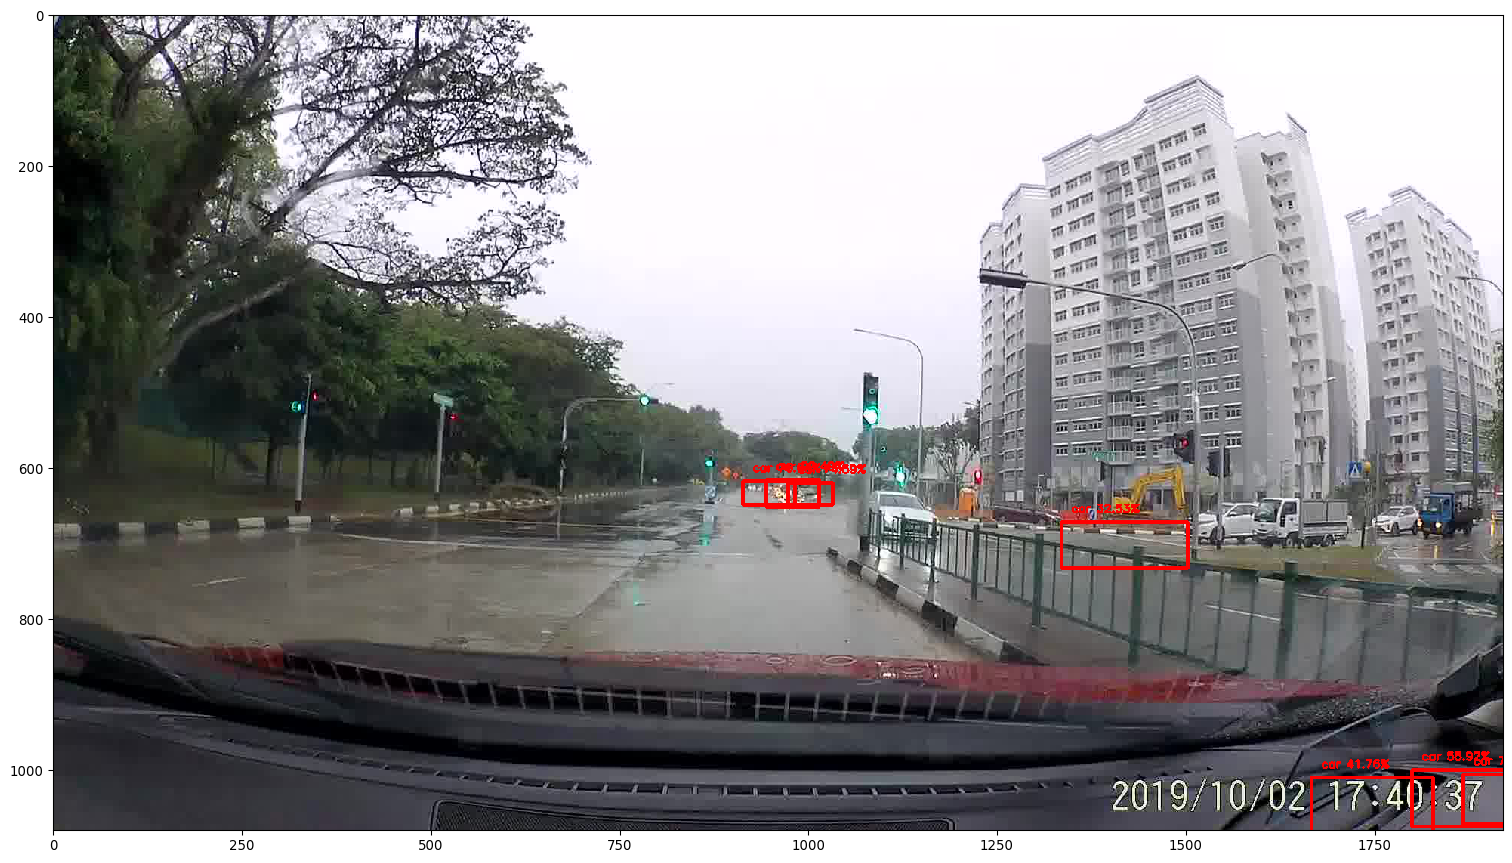

In [6]:
for img in test_images:
    img, pred = yoloAPI.predict(os.path.join(imgpath, img))
    img = yoloAPI.draw_prediction(img, pred)
    ia.imshow(img)

In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'val_yolo_loss_layer_4_loss', 'val_yolo_loss_layer_5_loss', 'val_yolo_loss_layer_6_loss', 'loss', 'yolo_loss_layer_4_loss', 'yolo_loss_layer_5_loss', 'yolo_loss_layer_6_loss', 'lr'])


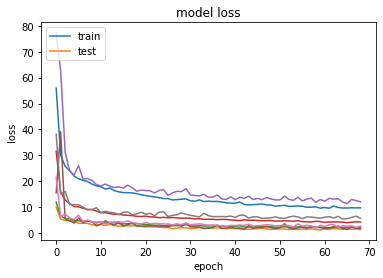

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['yolo_loss_layer_4_loss'])
plt.plot(history.history['yolo_loss_layer_5_loss'])
plt.plot(history.history['yolo_loss_layer_6_loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_yolo_loss_layer_4_loss'])
plt.plot(history.history['val_yolo_loss_layer_5_loss'])
plt.plot(history.history['val_yolo_loss_layer_6_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Conversion for OPENCV

In [14]:
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from keras import backend as K
import cv2

In [16]:
# Disable learning phase on Keras backend before loading weights
K.set_learning_phase(0)
frozen_model = yoloAPI.infer_model
frozen_model.load_weights('yolo_model.h5')

In [17]:
# Get keras session and convert to a graph
sess = K.get_session()
init_graph = sess.graph.as_graph_def()

In [20]:
MODEL_PATH = 'out'
MODEL_NAME = 'YOLOv3'
input_node_name = [node.op.name for node in frozen_model.inputs]
output_node_name = [node.op.name for node in frozen_model.outputs]

In [21]:
# Convert keras model to tensorflow .pb model, .pbtxt model text and model checkpoint file
tf.train.write_graph(sess.graph_def, MODEL_PATH, f'{MODEL_NAME}_graph.pb', as_text=False)
tf.train.write_graph(sess.graph_def, MODEL_PATH, f'{MODEL_NAME}_graph.pbtxt')
tf.train.Saver().save(sess, f'{MODEL_PATH}/{MODEL_NAME}.chkp')

'out/YOLOv3.chkp'

In [23]:
output_node_name

['conv2d_134/BiasAdd', 'conv2d_142/BiasAdd', 'conv2d_150/BiasAdd']

In [24]:
# Freeze converted tensorflow model
fg = freeze_graph.freeze_graph(f'{MODEL_PATH}/{MODEL_NAME}_graph.pbtxt',
                          None, 
                          False,
                          f'{MODEL_PATH}/{MODEL_NAME}.chkp',
                          'conv2d_134/BiasAdd,conv2d_142/BiasAdd,conv2d_150/BiasAdd', # replace with printout from output_node_name as single string
                          "save/restore_all",
                          "save/Const:0",
                          f'{MODEL_PATH}/frozen_{MODEL_NAME}.pb',
                          True, 
                          "",)

INFO:tensorflow:Restoring parameters from out/YOLOv3.chkp
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 366 variables.
INFO:tensorflow:Converted 366 variables to const ops.


In [25]:
# Write frozen tensorflow model to file
tf.train.write_graph(fg, '', 'frozen_yolov3.pb', as_text=False)

'frozen_yolov3.pb'

In [26]:
# Try to load frozen tensorflow model in OpenCV
net = cv2.dnn.readNetFromTensorflow('frozen_yolov3.pb')

error: C:\Anaconda2\conda-bld\opencv-contrib_1513946725639\work\opencv\modules\dnn\src\tensorflow\tf_importer.cpp:1296: error: (-2) Unknown layer type PlaceholderWithDefault in op batch_normalization_1/keras_learning_phase in function cv::dnn::experimental_dnn_v2::`anonymous-namespace'::TFImporter::populateNet
